In [1]:
from pylab import *
from utility_bfsolver3D import *

%matplotlib inline
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=12)

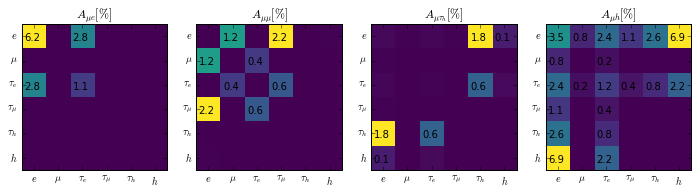

In [2]:
# defining bfCalc
tb = BFCalc3D_Toolbox()
df_acc = tb.IO_LoadAccTableIntoDf()
usetag = "1b"

a_e   = df_acc.loc[(df_acc.sel=="ee")   & (df_acc.tag==usetag),'acc'].values[0]
a_m   = df_acc.loc[(df_acc.sel=="emu2") & (df_acc.tag==usetag),'acc'].values[0]
a_t   = df_acc.loc[(df_acc.sel=="etau") & (df_acc.tag==usetag),'acc'].values[0]
a_h   = df_acc.loc[(df_acc.sel=="e4j")  & (df_acc.tag==usetag),'acc'].values[0]

plt.rc("figure",facecolor="w")
tb.Plot_Imshow4Matrix(a_e,a_m,a_t,a_h)

# 1. Load the yields data

In [3]:
bf  = BFCalc3D_ThreeSelectorRatios(a_e, a_m, a_t, a_h, xs=832+35.85*2, lumin=35847)

In [13]:
#list_bkg_unc = [39,12,37,196] # e-1b
#list_bkg_unc = [12,3,8,71] # e-2b

#5% crossection
#list_bkg_unc = [116,7,34,1124] # mu-1b
list_bkg_unc = [10,0.4,3,138] # mu-2b

bf  = BFCalc3D_ThreeSelectorRatios(a_e, a_m, a_t, a_h, xs=832+35.85*2, lumin=35847, 
                                    bkg_unc_e=list_bkg_unc[0],
                                    bkg_unc_m=list_bkg_unc[1],
                                    bkg_unc_t=list_bkg_unc[2],
                                    bkg_unc_h=list_bkg_unc[3]
                                  )

# 2. Generate Toys

[4.68558320e-05 2.34377172e-05 7.50401285e-05]


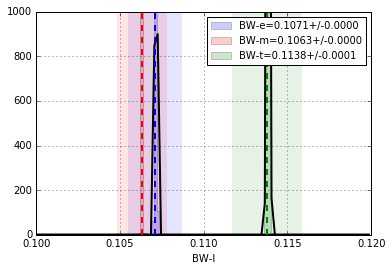

In [14]:
bf1_list, bf2_list, bf3_list = [],[],[]

for i in range(1000):
    #x1,x2,x3 = bf.PredictXs_SmearOfSubN()
    x1,x2,x3 = bf.ExpXs_SmearOfSubN()
    bf1,bf2,bf3  = bf.SovleBF(x1,x2,x3)
    
    bf1_list.append(bf1)
    bf2_list.append(bf2)
    bf3_list.append(bf3)

bf1_list = np.array(bf1_list)
bf2_list = np.array(bf2_list)
bf3_list = np.array(bf3_list)


delta_bf_toy = np.array([bf1_list.std(),bf2_list.std(),bf3_list.std()])
print(delta_bf_toy)
tb.Plot_toy( bf1_list,bf2_list,bf3_list)

In [5]:
# analytical error propagation
norm = 0
norm = bf.BFCalc3D_N_e.PredictYield()
norm+= bf.BFCalc3D_N_m.PredictYield()
norm+= bf.BFCalc3D_N_t.PredictYield()
norm+= bf.BFCalc3D_N_h.PredictYield()
x1,x2,x3 = bf.PredictXs()

ep = BFCalc3D_ErrorPropagater(bf,x1,x2,x3,norm,usetag)

In [12]:
np.tensordot(ep.grad2_g_x(),ep.var_x)**0.5

array([0.0012721 , 0.00217992, 0.00263382])

# 3. Plot extraction concept

In [10]:
bf1 = np.arange(0.102, 0.111, 0.0002)
bf2 = np.arange(0.102, 0.111, 0.0002)
len1 = len(bf1)
len2 = len(bf2)
bf1, bf2 = np.meshgrid(bf1, bf2)

bf3_e,bf3_m,bf3_t = [],[],[]
for x in range(len1):
    for y in range(len2):
        r1_,r2_ = bf1[x,y],bf2[x,y]
        
        bf3_e.append(bf.Sovle_BWt(r1_,r2_,x1,'e'))
        bf3_m.append(bf.Sovle_BWt(r1_,r2_,x2,'m'))
        bf3_t.append(bf.Sovle_BWt(r1_,r2_,x3,'t'))
bf3_e = np.array(bf3_e).reshape(len1,len2)
bf3_m = np.array(bf3_m).reshape(len1,len2)
bf3_t = np.array(bf3_t).reshape(len1,len2)

In [12]:
import plotly.plotly as py
from plotly.graph_objs import Surface
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

mm = go.Surface(x=bf1, y=bf2, z=bf3_e, 
                surfacecolor = 0*np.ones_like(bf3_e),
                cmin=-1,cmax=2, showscale = False, opacity=1, name='mm channel')
mt = go.Surface(x=bf1, y=bf2, z=bf3_m,  
                surfacecolor = 1*np.ones_like(bf3_m),
                cmin=-1,cmax=2, showscale = False, opacity=1, name='mt channe' )
em = go.Surface(x=bf1, y=bf2, z=bf3_t,
                surfacecolor = 2*np.ones_like(bf3_t),
                cmin=-1,cmax=2, showscale = False, opacity=1, name='em channe' )

pdg = go.Scatter3d(x=np.array([0.1071]),y=np.array([0.1063]),z=np.array([0.1138]),mode='markers', marker=dict(size=10,color='black'))

toy = go.Scatter3d(x=bf1_list[:1000],y=bf2_list[:1000],z=bf3_list[:1000],mode='markers', marker=dict(size=2,color='green'))


pdgB = go.Scatter3d(x=np.array([0.1071,0.1071]),y=np.array([0.1063,0.1063]),z=np.array([0.09,0.14]),mode='lines', 
                    marker=dict(size=10, color='black',line = dict(width = 100)))

layout = go.Layout(scene=dict( xaxis=dict(title='BW_e'), yaxis=dict(title='BW_mu'), zaxis=dict(title='BW_tau')),
                   margin=dict(l=0,r=0,b=0,t=0))

fig = go.Figure(data=[mm,mt,em,pdg,pdgB],layout = layout)
iplot(fig)